## Methodology

1. Load metadata for reference network. This is the network whose station(s) clocks are considered reliable reference.
1. Load metadata for network which is the target of GPS clock correction.
1. Initialize "good" set of stations with the reference network.
1. Initialize "pending" set of stations with the target network.
1. For each station in "pending", starting with the closest to one of the "good" stations:
  1. _Attempt to determine GPS clock corrections_ for target station against closest "good" station.
  1. If successful, add station to the "good" set, otherwise add to "bad" (uncorrected) set.
  1. Choose next target station as the one closest to a "good" station.
  1. Repeat until no more "pending" stations.
  
## Algorithm for determining clock corrections

* Based on time series of station pair correlations.
* Corrections need to be plausible.
* Ideas: RANSAC or Theil-Sen regression to dominant mode, then remove those points and repeat or analyze the residual clusters separately.

In [1]:
import os
import pdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#from importlib import reload
#reload(seismic)


In [4]:
from seismic.xcorqc.correlator import Dataset
from netCDF4 import Dataset as NCDataset
from obspy.core import Stream, UTCDateTime

In [5]:
import scipy
from scipy import signal

In [6]:
CORRELATIONS_DB_PATH = "/g/data/ha3/rakib/xcorTest/7X"

In [7]:
# Location of source files for extracting network metadata (reference clocks)
REF_NETWORK_META = r"/g/data/ha3/rakib/_ANU/7G(2013-2015)/refData/7G.refdata.h5"

In [8]:
# Location of source files for extracting network metadata (targets of correction)
TARGET_NETWORK_META = r"/g/data/ha3/Passive/_ANU/7G(2013-2015)/ASDF/7G(2013-2015).h5"

In [9]:
ds_ref = Dataset(REF_NETWORK_META)
ds_ref.ds

/home/547/am7399/venv/py3.5.2/lib/python3.5/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


ASDF file [format version: 1.0.2]: '../../../../../../../../data/ha3/rakib/_ANU/7G(2013-2015)/refData/7G.refdata.h5' (3.3 GB)
	Contains 0 event(s)
	Contains waveform data from 1 station(s).

In [10]:
ds_targ = Dataset(TARGET_NETWORK_META)
ds_targ.ds

ASDF file [format version: 1.0.0]: '../../../../../../../../data/ha3/Passive/_ANU/7G(2013-2015)/ASDF/7G(2013-2015).h5' (197.9 GB)
	Contains 0 event(s)
	Contains waveform data from 44 station(s).
	Contains 1 type(s) of auxiliary data: LogfileData

In [11]:
# ds_ref.stations_metadata

In [12]:
# ds_targ.stations_metadata

In [13]:
known_good = ds_ref.stations
# Everything in pending should end up in known_good, known_bad or skipped.
pending = ds_targ.stations
known_bad = []
skipped = []

In [14]:
# Correction objects indexed by target network station code.
corrections = {}

In [15]:
# def determineGpsCorrections(stn_targ, nearest_good, max_correction_sec=300):
#     pdb.set_trace()
#     xcorr_fname = ".".join([stn_targ, nearest_good]) + ".nc"
#     xcorr_fname = os.path.join(CORRELATIONS_DB_PATH, xcorr_fname)
#     if os.path.exists(xcorr_fname):
#         ds_xcorr = NCDataset(xcorr_fname, 'r')
#         print(ds_xcorr)
#         start_times = ds_xcorr.variables['IntervalStartTimes'][:]
#         lag = ds_xcorr.variables['lag'][:]
#         xcorr = ds_xcorr.variables['xcorr'][:, :]    
#         num_stacked = ds_xcorr.variables['NumStackedWindows'][:]
# #        return True, {}
#         return False, None
#     else:
#         return False, None

In [16]:
# for stn_targ in pending:
#     pdb.set_trace()
#     nearest_good = ds_targ.get_closest_stations(stn_targ, ds_ref, 1)
#     nearest_good = nearest_good[0]
#     print("Analysing {} against nearest reference station {}".format(stn_targ, nearest_good))
#     success, stn_corrections = determineGpsCorrections(stn_targ, nearest_good)
#     if success:
#         corrections[stn_targ] = stn_corrections
#         known_good.append(stn_targ)
# #        ds_ref.add(ds_targ.stations[stn_targ])
#     elif stn_corrections is None:
#         skipped.append(stn_targ)
#     else:
#         known_bad.append(stn_targ)


In [17]:
testfile = os.path.join(CORRELATIONS_DB_PATH, 'MA51.QIS.nc')

In [45]:
ds_xcorr = NCDataset(testfile, 'r')
print(ds_xcorr)
start_times = ds_xcorr.variables['IntervalStartTimes'][:]
lag = ds_xcorr.variables['lag'][:]
xcorr = ds_xcorr.variables['xcorr'][:, :]    
num_stacked = ds_xcorr.variables['NumStackedWindows'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Cross-correlation results for station-pair: MA51.QIS
    dimensions(sizes): interval(113), lag(287999)
    variables(dimensions): float32 interval(interval), float32 lag(lag), float32 NumStackedWindows(interval), int64 IntervalStartTimes(interval), int64 IntervalEndTimes(interval), float32 xcorr(interval,lag)
    groups: 



In [46]:
# Truncate the lag axis to a smaller time range for prototyping purposes.
# Truncate to 5 minutes either size of zero, with sampling rate as 50 Hz
proto_lag_duration = int(10*60*50)
print(proto_lag_duration)
offset = int(np.floor((lag.size - proto_lag_duration)/2))

30000


In [47]:
lag_r = lag[offset:offset + proto_lag_duration]
xcorr_r = xcorr[:, offset:offset + proto_lag_duration]

In [ ]:
# Load real data having no shift.
# Synthesize a shift in it.
# Test the detection method after folding to see if it still works.

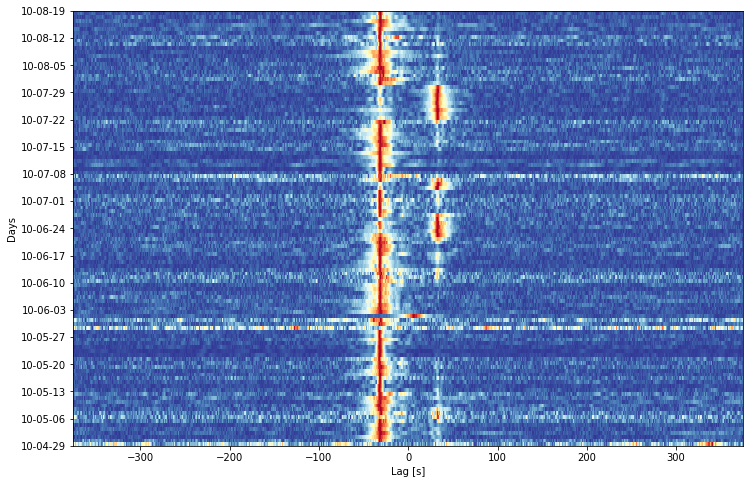

In [48]:
gx, gy = np.meshgrid(lag_r, start_times)
plt.figure(figsize=(12,8))
im = plt.pcolormesh(gx, gy, xcorr_r, cmap='RdYlBu_r')
labels=[]
for st in start_times: 
   labels.append(UTCDateTime(st).strftime("%y-%m-%d"))
plt.yticks(start_times[::7], labels[::7])
plt.xlabel('Lag [s]')
plt.ylabel('Days')
plt.show()

In [49]:
# Fold xcorr
xcorr_f = xcorr + np.fliplr(xcorr)
xcorr_f = xcorr_f/np.max(xcorr_f)

In [50]:
print(start_times.shape)
print(lag.shape)
print(xcorr_f.shape)

(113,)
(287999,)
(113, 287999)


In [51]:
lag_0 = lag[offset:offset + proto_lag_duration]
xcorr_0 = xcorr_f[:, offset:offset + proto_lag_duration]

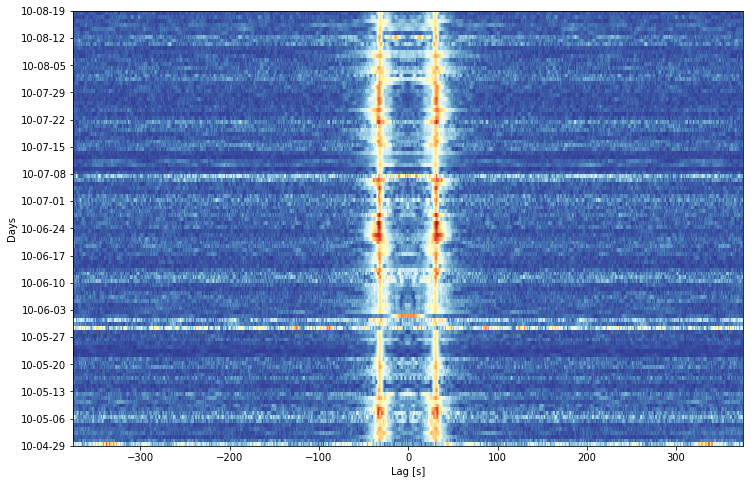

In [52]:
gx, gy = np.meshgrid(lag_0, start_times)
plt.figure(figsize=(12,8))
im = plt.pcolormesh(gx, gy, xcorr_0, cmap='RdYlBu_r')
labels=[]
for st in start_times: 
   labels.append(UTCDateTime(st).strftime("%y-%m-%d"))
plt.yticks(start_times[::7], labels[::7])
plt.xlabel('Lag [s]')
plt.ylabel('Days')
plt.show()

In [23]:
type(xcorr_0)

numpy.ma.core.MaskedArray

In [24]:
rcf = np.sum(xcorr_0, axis=0)/xcorr_0.shape[0]

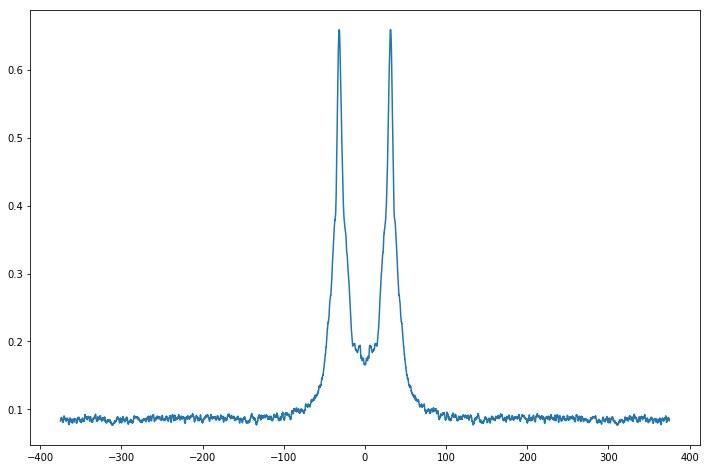

In [25]:
plt.figure(figsize=(12,8))
plt.plot(lag_0, rcf)

In [26]:
rcf.shape

(30000,)

In [27]:
xcorr_0.shape

(113, 30000)

In [28]:
# Use scipy/numpy broadcast rules to apply conv of rcf to each row.
rcf.shape = (1, 30000)
ccf_rcf = scipy.signal.convolve(xcorr_0, rcf, mode='same')

In [29]:
ccf_rcf.shape

(113, 30000)

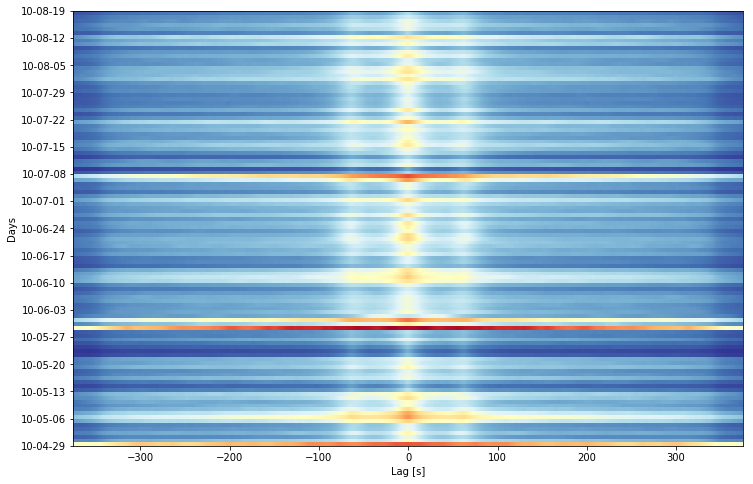

In [30]:
gx, gy = np.meshgrid(lag_0, start_times)
plt.figure(figsize=(12,8))
im = plt.pcolormesh(gx, gy, ccf_rcf, cmap='RdYlBu_r')
labels=[]
for st in start_times: 
   labels.append(UTCDateTime(st).strftime("%y-%m-%d"))
plt.yticks(start_times[::7], labels[::7])
plt.xlabel('Lag [s]')
plt.ylabel('Days')
plt.show()

In [31]:
x = xcorr_0[100,:]
rcf.shape = (30000,)
c = np.convolve(x, rcf, mode='same')
c.shape

(30000,)

Text(0.5, 1.0, 'Verify scipy.signal.convolve is broadcasting as expected')

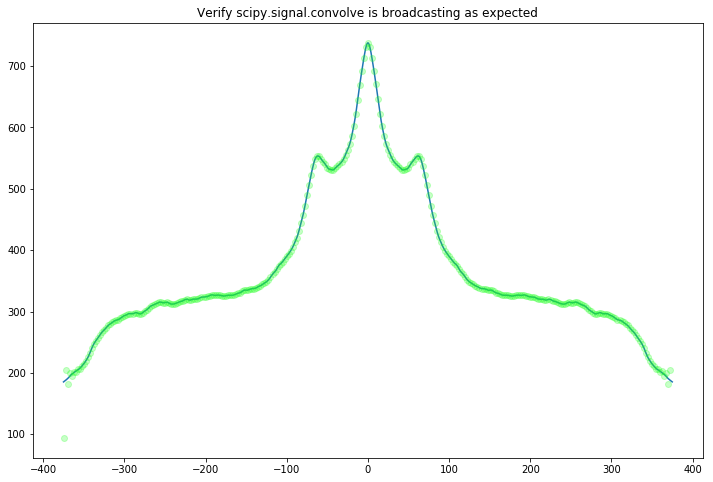

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(lag_0, ccf_rcf[100, :])
plt.plot(lag_0[::100], scipy.signal.decimate(c, 100, ftype='fir'), 'o', color='#20ff2040')
plt.title("Verify scipy.signal.convolve is broadcasting as expected")

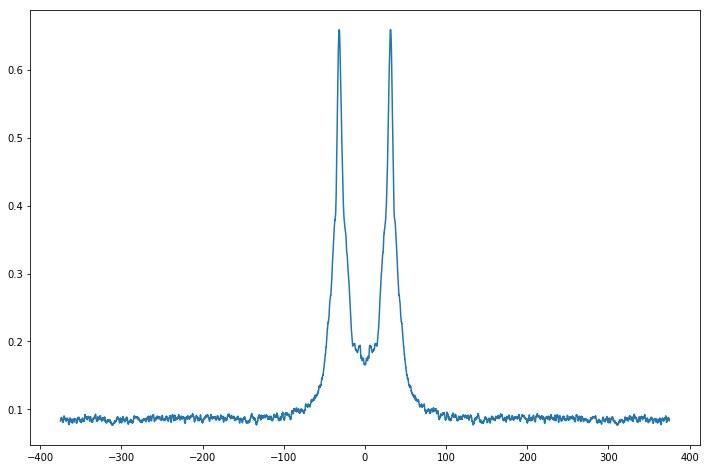

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(lag_0, rcf)
# for i in range(32, 34):
#     plt.plot(xcorr_0[i, :])

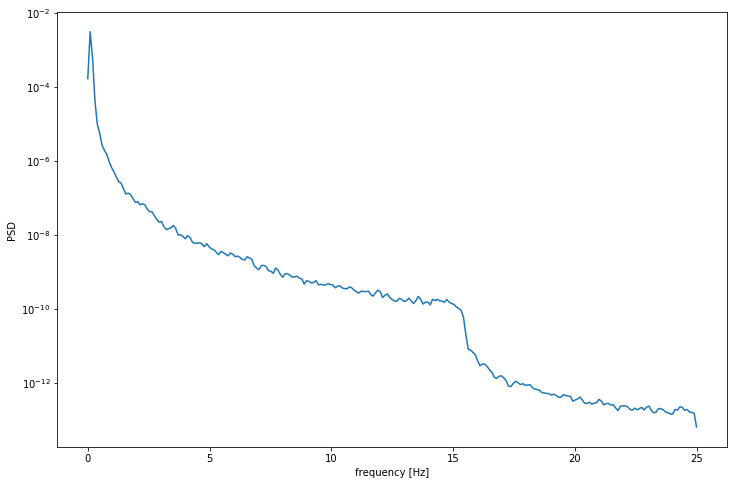

In [36]:
# Examine spectral content of RCF versus selected CCFs
fs = 50.0
f, Pxx_den = signal.welch(rcf, fs, nperseg=512)
plt.figure(figsize=(12,8))
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [37]:
order = 8
fcut = 0.5
b, a = scipy.signal.butter(order, fcut/(fs/2.0), btype='low', analog=False)

In [38]:
b

array([8.09825979e-13, 6.47860783e-12, 2.26751274e-11, 4.53502548e-11,
       5.66878185e-11, 4.53502548e-11, 2.26751274e-11, 6.47860783e-12,
       8.09825979e-13])

In [39]:
a

array([  1.        ,  -7.67794021,  25.79721953, -49.54122564,
        59.47613197, -45.70873448,  21.96012013,  -6.03017224,
         0.72460093])

In [40]:
rcf_filt = scipy.signal.filtfilt(b, a, rcf)

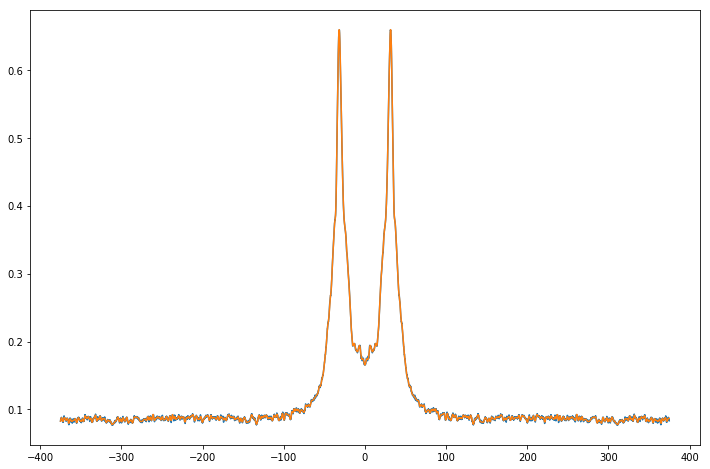

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(lag_0, rcf)
plt.plot(lag_0, rcf_filt)

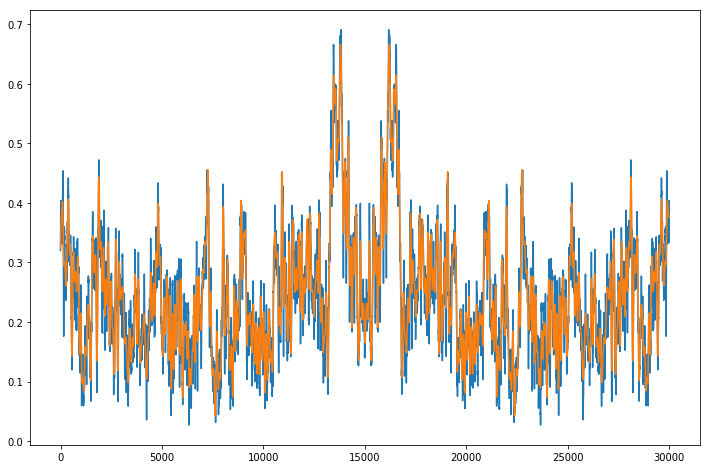

In [44]:
xcorr_0_filt = scipy.signal.filtfilt(b, a, xcorr_0[32,:])
plt.figure(figsize=(12, 8))
plt.plot(xcorr_0[32,:])
plt.plot(xcorr_0_filt)

In [ ]:
# TODO: experiment with clipping off nouse floor on RCF
